the third sequence of images sequence without any calibration

- image recorded: `scene.hdf5`

We try to denoise the scene without using any calibration dataset

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

# 3A. Load data

In [2]:
dataset_location = "C:/Users/thang/OneDrive/Desktop/school/DataChallenge/dataset_for_students/"

In [3]:
scene_df_1 = pd.read_hdf(dataset_location + 'scene.hdf5')
scene_df_2 = pd.read_hdf(dataset_location + 'scene2.hdf5')
scene_df_3 = pd.read_hdf(dataset_location + 'scene3.hdf5')

In [4]:
def display(scene_df, corrected_scene_images,index=15):
    plt.figure(figsize=(15, 5))

    # Original scene image
    plt.subplot(1, 2, 1)
    plt.title("Original Scene Image")
    plt.imshow(scene_df['image'][index], cmap='gray')

    # Denoised scene image
    plt.subplot(1, 2, 2)
    plt.title("Denoised Scene Image")
    plt.imshow(corrected_scene_images[index], cmap='gray')

    plt.show()

## 3.0 Analyse calibration

In [6]:
calibration_df1 = pd.read_hdf(dataset_location +'calibration_set_1.hdf5')
calibration_df2 = pd.read_hdf(dataset_location +'calibration_set_2.hdf5')

In [10]:
def evaluate_distributions(array):
    """
    This function evaluates and visualizes the distribution of values in a 2D array.

    Parameters:
    array (numpy.ndarray): A 2D numpy array of values.

    Returns:
    None
    """

    # Flatten the 2D array to 1D for distribution analysis
    flattened_array = array.flatten()

    # Calculate basic statistics
    mean = np.mean(flattened_array)
    median = np.median(flattened_array)
    std_dev = np.std(flattened_array)

    # Print basic statistics
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")

    # Plot the histogram of the values
    plt.hist(flattened_array, bins=30, edgecolor='black')
    plt.title('Distribution of Values in 2D Array')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    return mean, median, std_dev

In [11]:
def estimate_parameters(calibration_df):
    calibration_images = calibration_df['image'].values
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    
    # Ensure calibration_images is a numeric array
    calibration_images = np.array(calibration_images.tolist(), dtype=np.float32)
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)

    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = torch.tensor(calibration_images, dtype=torch.float32).to(device)
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).to(device)

    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width

    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.to(device)

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).to(device)], dim=1)

    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]

    # Reshape back to original image shape
    offsets = offsets.view(height, width).to(device).numpy()
    responsivities = responsivities.view(height, width, -1).to(device).numpy()

    return offsets, responsivities


In [12]:
offset1,gain1 = estimate_parameters(calibration_df1)

Mean: 6503.77099609375
Median: 6496.5458984375
Standard Deviation: 248.81651306152344


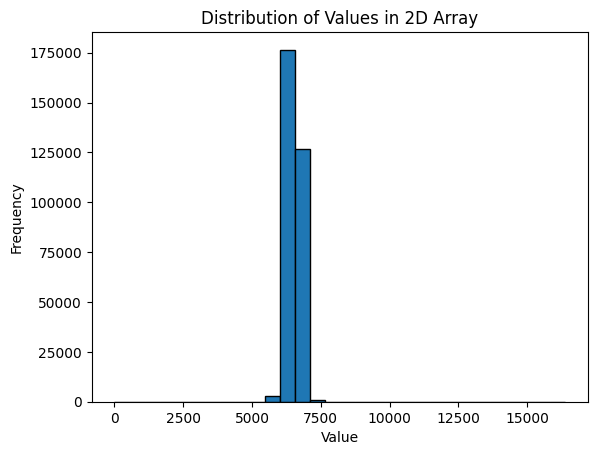

Mean: -63.88544845581055
Median: -64.01828002929688
Standard Deviation: 7.321582794189453


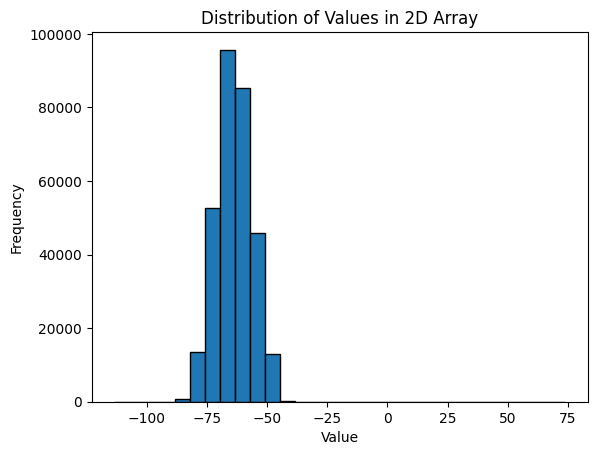

Mean: 13.8864107131958
Median: 13.900863647460938
Standard Deviation: 0.27165839076042175


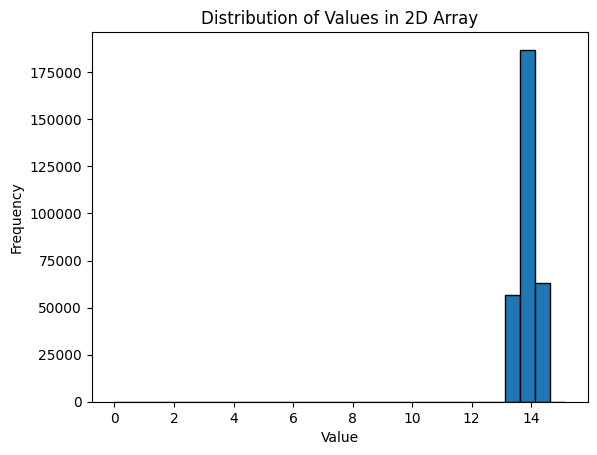

In [13]:
mean_offset1, median_offset1, std_dev_offset1= evaluate_distributions(offset1)
mean_fpa, median_fpa, std_dev_fpa= evaluate_distributions(gain1[:,:,0])
mean_cn, median_cn, std_dev_cn= evaluate_distributions(gain1[:,:,1])

# 3B. Approach

## 3.1 Mean and Median

### 3.1.1 Mean

In [14]:
def mean_denoised_df(scene_df):

    baseline = np.mean(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)-baseline


In [15]:
mean_img = mean_denoised_df(scene_df_1)

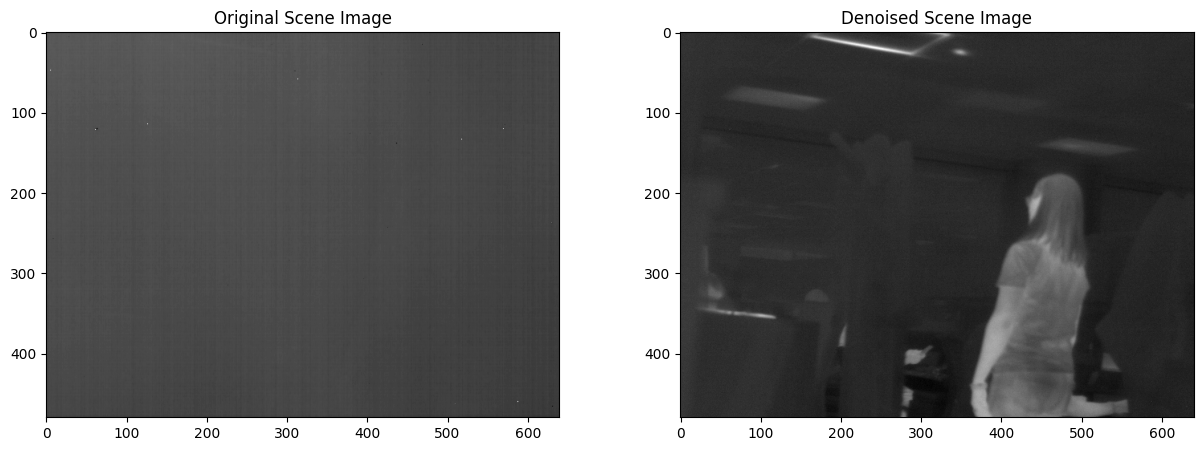

In [18]:
display(scene_df_1, mean_img,index=350)

### 3.1.2 Median

In [19]:
def median_denoised_df(scene_df):

    baseline = np.median(np.array(np.stack(scene_df["image"].values)), axis =0)

    return np.stack(scene_df["image"].values)- baseline

In [20]:
median_img = median_denoised_df(scene_df_1)

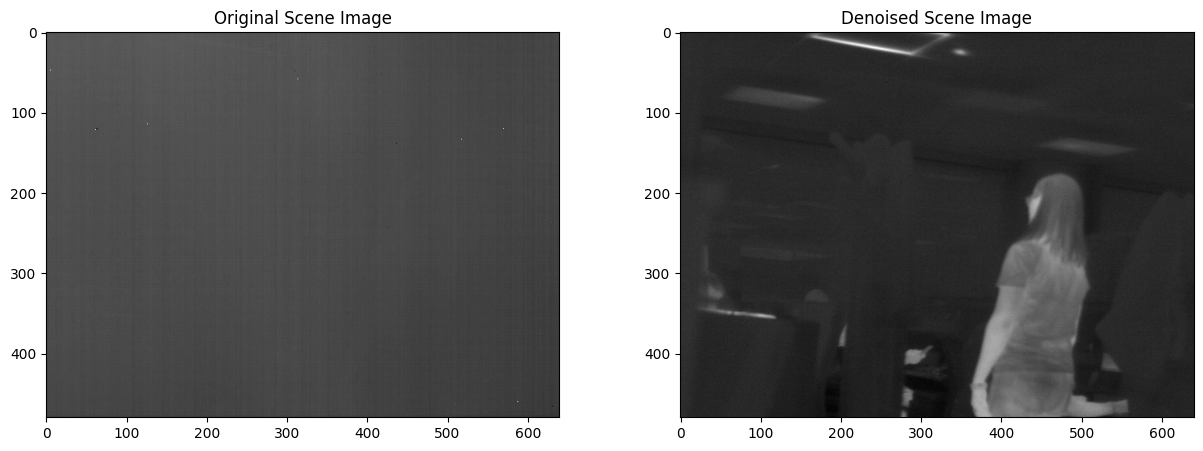

In [22]:
display(scene_df_1, median_img,index=350)

### 3.1.3 Common values of mean and median

**Problem:**
the darker imprint which is left from when the car stops and remains in the same position through multiple frames

In [26]:
def process_data(df):
    df_image = df['image'].values
    return np.stack(df_image)


#### 3.1.3.a without threshold

In [70]:
def common_values(x, y, threshold=100):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

In [90]:
arr = process_data(scene_df_1)
mean_img = np.median(arr, axis =0)
median_img = np.mean(arr, axis =0)
common = common_values(mean_img, median_img, 1000)

corrected_img = arr-common

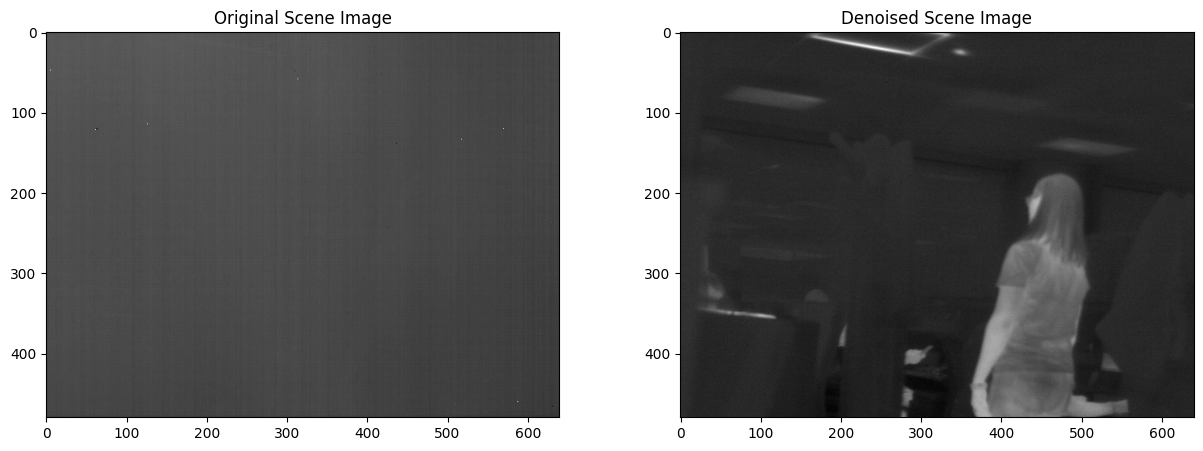

In [91]:
display(scene_df_1, corrected_img,index=350)

#### 3.1.3.b with threshold

In [81]:
import numpy as np
from scipy.ndimage import label

def common_values_within_threshold(x, y, threshold=500):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

def detect_black_chunks(image):
    # Ensure the image is a binary image (black and white)
    binary_image = (image == 0).astype(int)
    
    # Label connected components
    labeled_image, num_features = label(binary_image)
    
    # Extract indices of black pixel chunks
    chunks = []
    for i in range(1, num_features + 1):
        chunk_indices = np.argwhere(labeled_image == i)
        chunks.append(chunk_indices)
    
    return chunks

def normalize_image(image):
    # Normalize the image to the range [0, 1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def fill_black_pixels(arr, threshold=500, max_iterations=100):
    initial_indices = np.random.choice(arr.shape[0], size=10, replace=False)
    initial_subset = arr[initial_indices]
    
    # Update the common image with new mean and median from the subset
    initial_subset_median = np.median(initial_subset, axis=0)
    initial_subset_mean = np.mean(initial_subset, axis=0)
    initial_common = common_values_within_threshold(initial_subset_mean, initial_subset_median, threshold)
    
    black_chunks = detect_black_chunks(initial_common)
    
    filled_image = initial_common.copy()
    
    # Store the initial state
    filled_images_history = [filled_image.copy()]
    
    for iteration in range(max_iterations):
        if not black_chunks:
            break
        
        # Randomly select a subset of images
        subset_indices = np.random.choice(arr.shape[0], size=10, replace=False)
        subset = arr[subset_indices]
        
        # Update the common image with new mean and median from the subset
        subset_median = np.median(subset, axis=0)
        subset_mean = np.mean(subset, axis=0)
        subset_common = common_values_within_threshold(subset_mean, subset_median, threshold)
        
        # Normalize the subset_common image
        subset_common = normalize_image(subset_common)
        
        # Fill the black pixel chunks
        for chunk in black_chunks:
            for (x, y) in chunk:
                if filled_image[x, y] == 0 and subset_common[x, y] != 0:
                    filled_image[x, y] = subset_common[x, y]
        
        # Store the intermediate filled image
        filled_images_history.append(filled_image.copy())
        
        # Re-detect black chunks
        black_chunks = detect_black_chunks(filled_image)
    
    # Normalize the final filled image
    filled_image = normalize_image(filled_image)
    
    return filled_image, filled_images_history

# Example usage
# arr = np.random.randint(0, 256, (100, 480, 640), dtype=np.uint8)
# final_image, history = fill_black_pixels(arr)

In [93]:
thresh = 0.001
arr = process_data(scene_df_1)
norm_arr = normalize_image(arr)
result, layers = fill_black_pixels(norm_arr, thresh)

corrected_img = norm_arr - result

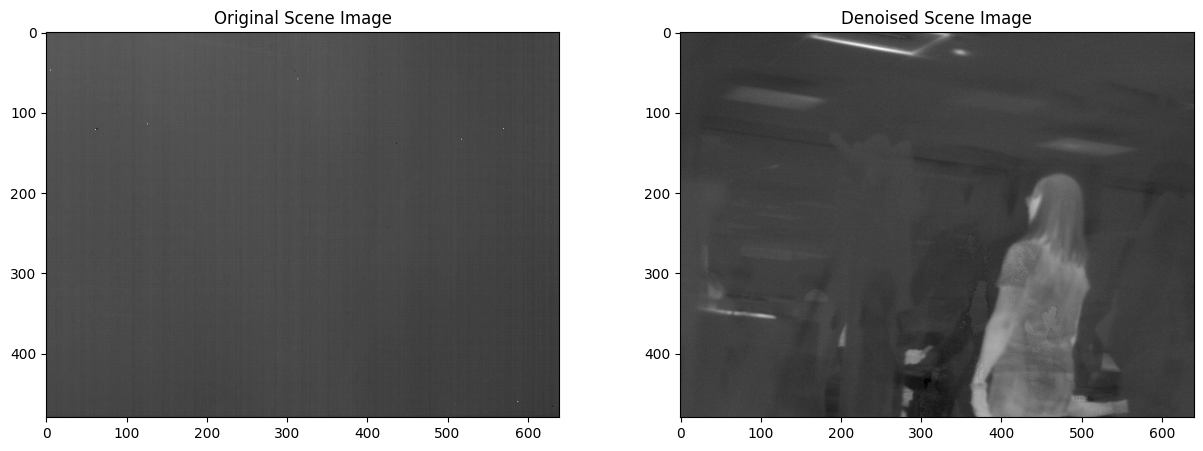

In [94]:
display(scene_df_1, corrected_img,index=350)

### 3.1.4 median filter adaptive subtraction

In [96]:
def compute_median_background(frames):
    median_frame = np.median(frames, axis=0)
    return median_frame

def subtract_background(frames, background):
    return frames - background

def morphological_operations(frame):
    kernel = np.ones((5,5), np.uint8)
    eroded = cv2.erode(frame, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    return dilated

In [100]:
frames = process_data(scene_df_1)
background_median = compute_median_background(frames)
denoised_frames = subtract_background(frames, background_median)

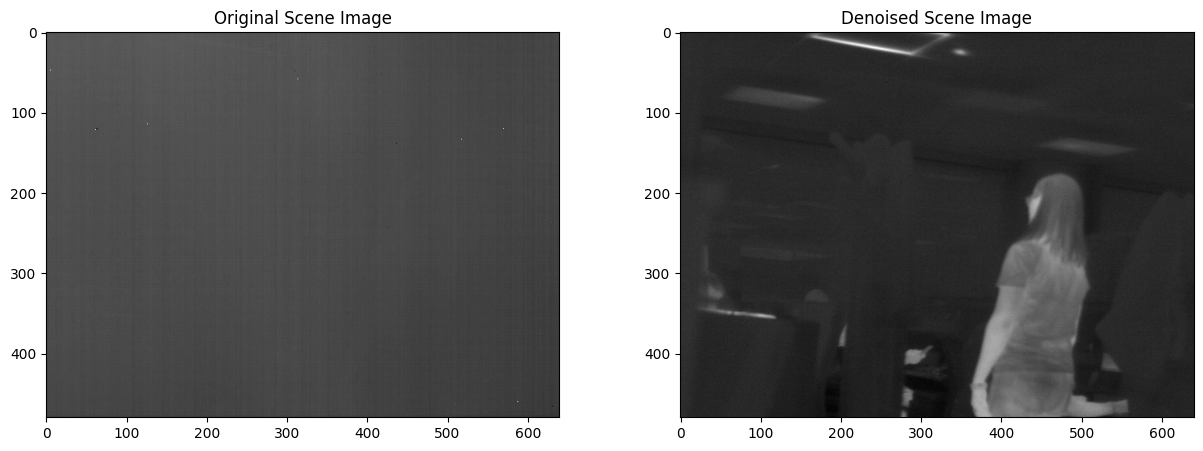

In [101]:
display(scene_df_1, denoised_frames,index=350)

## 3.2 Pseudo calibration


### 3.2.1 sort uniform block of image

Compute the variance of each block

**Problem:** faceing the mosaic effect

In [115]:
def slice_array(arr, num = 10):
    t, x, y = arr.shape
    
    # Ensure x and y are divisible by 10
    assert x % num == 0 and y % num == 0, "Dimensions x and y must be divisible by 10"
    
    slices = []
    
    for i in range(num):
        for j in range(num):
            slice_x_start = i * (x // num)
            slice_x_end = (i + 1) * (x // num)
            slice_y_start = j * (y // num)
            slice_y_end = (j + 1) * (y // num)
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append(slice_ij)
    
    return slices

def rebuild_array(slices, original_shape, num = 10):
    x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros(( x, y))
    
    for idx, slice_ij in enumerate(slices):
        i = idx // num
        j = idx % num
   
        slice_x_start = i * (x // num)
        slice_x_end = (i + 1) * (x // num)
        slice_y_start = j * (y // num)
        slice_y_end = (j + 1) * (y // num)
        
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] = slice_ij
    
    return rebuilt_array

In [118]:
def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices


def sorted_least_mean_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    means = np.mean(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(means)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

In [119]:
def pick_regular_slices(arr,num):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices

In [120]:
def adjust_mean_to_target(arr, target_mean):
    """
    Adjust the values of a 2D array uniformly so that its mean is as close as possible to a target value.

    Parameters:
    arr (np.ndarray): Input 2D array.
    target_mean (float): Target mean value.

    Returns:
    np.ndarray: Adjusted 2D array.
    """
    current_mean = np.mean(arr)
    difference = target_mean - current_mean
    adjusted_array = arr - difference
    return adjusted_array

In [122]:
def process_data(df):
    df_image = df['image'].values
    return np.stack(df_image)

In [123]:
def pseud_calibration(df, num_slices, reg= 100,adjust =None):
    arr = process_data(df)
    slices = slice_array(arr, num_slices)
    _, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s) for s in slices]
    # original_means = [np.mean(s) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s,reg) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    if adjust is not None:
        adjusted = [adjust_mean_to_target(m, adjust) for m in meaned]
    return rebuild_array(meaned, (x, y), num_slices)

In [124]:
def applier(df):
    filter = pseud_calibration(df, 32)
    scene = process_data(df)
    filtered_scene = scene - filter
    return filtered_scene

corrected_img = applier(scene_df_1)

(400, 15, 20)


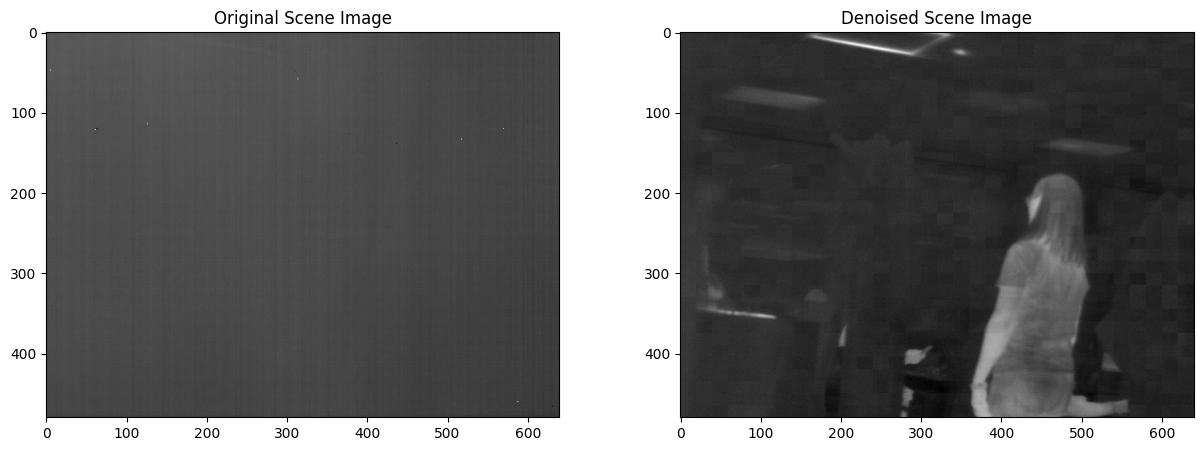

In [125]:
display(scene_df_1, corrected_img,index=350)

#### 3.2.1.a Stitching block

Don't see any code in github, have to ask WP

#### 3.2.1.b Overlap block

In [127]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros((x, y))
    weight = np.zeros((x, y))
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

In [128]:
def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num=50):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices


In [129]:
def adjust_contrast(image, alpha, beta):
    """
    Adjust the contrast of a grayscale image.

    Parameters:
    image (np.ndarray): Input grayscale image as a NumPy array.
    alpha (float): Contrast control (1.0-3.0).
    beta (int): Brightness control (0-100).

    Returns:
    np.ndarray: Image with adjusted contrast.
    """
    # Apply the contrast adjustment
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    return adjusted_image

In [130]:
def process_data(df):
    df_image = df['image'].values
    return np.stack(df_image)

In [131]:
def pseud_calibration(df, num_slices):
    arr = process_data(df)
    slices = slice_array(arr, num_slices,4)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    # original_means = [np.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [132]:
def applier(df):
    filter = pseud_calibration(df, 32)
    scene = process_data(df)
    filtered_scene = scene - filter
    corrected_scene = adjust_contrast(filtered_scene, alpha=1.1, beta=100)
    return corrected_scene

corrected_img = applier(scene_df_1)

(400, 15, 20)


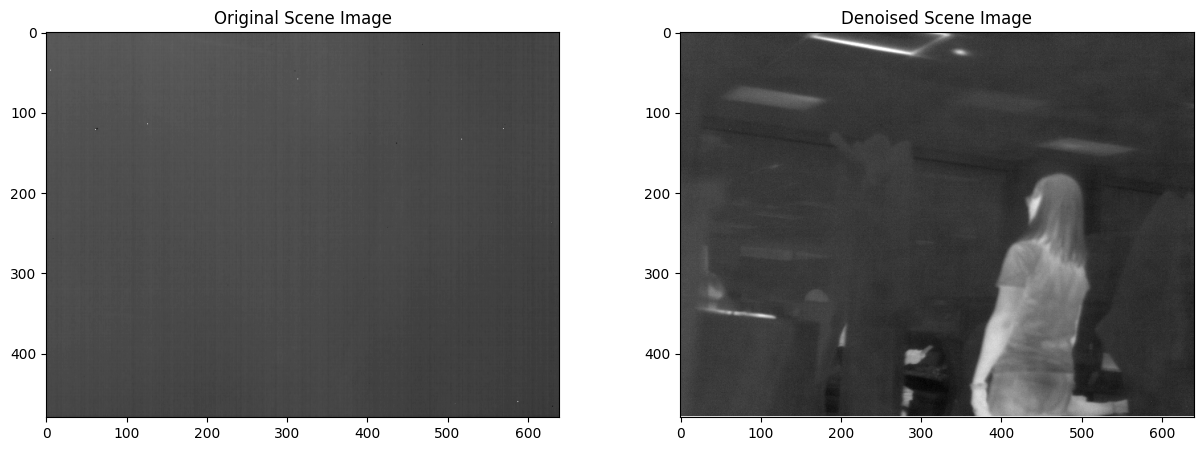

In [133]:
display(scene_df_1, corrected_img,index=350)

### 3.2.2 Transform to tensor

**Problem:** slower than matrix numpy

In [ ]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = torch.zeros((x, y), device=device)
    weight = torch.zeros((x, y), device=device)
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = torch.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = torch.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num=50):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = torch.arange(0, t, step, device=device)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices


In [ ]:
def adjust_contrast(image, alpha, beta):
    """
    Adjust the contrast of a grayscale image.

    Parameters:
    image (np.ndarray): Input grayscale image as a NumPy array.
    alpha (float): Contrast control (1.0-3.0).
    beta (int): Brightness control (0-100).

    Returns:
    np.ndarray: Image with adjusted contrast.
    """
    # Apply the contrast adjustment
    adjusted_image = torch.clamp(alpha * image + beta, 0, 255).type(torch.float32)
    
    return adjusted_image

In [ ]:
def process_data(df):
    df_image = df['image'].values
    df_image = np.array(df_image.tolist(), dtype=np.float32)
    df_image = torch.tensor(df_image, dtype=torch.float32).to(device)
    return df_image


In [ ]:
def pseud_calibration(df, num_slices):
    arr = process_data(df)
    slices = slice_array(arr, num_slices,4)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    # original_means = [torch.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s) for s in medslice]
    meaned = [torch.mean(t, dim=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [ ]:
def applier(df):
    filter = pseud_calibration(df, 32)
    scene = process_data(df)
    filtered_scene = scene - filter
    corrected_scene = adjust_contrast(filtered_scene, alpha=1.1, beta=100)
    corrected_scene = corrected_scene.to(device).numpy()
    return corrected_scene

corrected_img = applier(scene_df_1)

# 3C. Final method

# 3D. Evaluation

In [ ]:
def applier_for_metric(df):
    filter = pseud_calibration(df, 32)
    scene = process_data(df)
    filtered_scene = scene - filter
    return scene, filter, filtered_scene

# 3E. Conclusion